In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
import warnings
import html
import emoji 
import nltk
from nltk.corpus import stopwords
import pycountry
import torch
nltk.download('stopwords')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer
import torch

In [18]:
def flatten_list(nested_list):
    """
    Flattens a nested list of lists into a single list. Treats strings as individual elements.
    
    Args:
    nested_list (list): A list that may contain nested lists.
    
    Returns:
    list: A flattened version of the nested list.
    """
    flat_list = []
    for element in nested_list:
        if isinstance(element, list):
            # If the element is a list, extend flat_list with the flattened version of this element
            flat_list.extend(flatten_list(element))
        else:
            # If the element is not a list (including strings), append it directly to flat_list
            flat_list.append(element)
    return flat_list

In [19]:
import pycountry
from nltk.corpus import stopwords
nltk.download('stopwords')
def get_language_name(abbr):
    try:
        return pycountry.languages.get(alpha_2=abbr).name.lower()
    except AttributeError:
        return 'english'

def get_all_words_languages(languages):
    all_lang = [get_language_name(language) for language in languages]
    all_lang = [lang for lang in all_lang if lang in stopwords.fileids()]
    all_stopwords = [list(set(stopwords.words(lang_code))) for lang_code in all_lang]
    return flatten_list(all_stopwords)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\felip\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [20]:
import pandas as pd
import emoji
import html

def append_if_different(title, text):
    if title[:-1] == text[:len(title)-1]:
        return text
    elif title != text:
        return title + ' ' + text 
    else:
        return text
    
df = pd.read_csv('../data/raw/data.csv', index_col=0)
df['created_date'] = pd.to_datetime(df['created_date'], utc=True)
df.dropna(subset=['Text', 'stars'], inplace=True)
df['Text'] = df['Text'].apply(lambda x: emoji.demojize(html.unescape(x), delimiters=(" ", " ")))
df['Title'] = df['Title'].apply(lambda x: emoji.demojize(html.unescape(x), delimiters=(" ", " ")))
df['full_text'] = df.apply(lambda row: append_if_different(row['Title'], row['Text']), axis=1)
df = df.sort_values(by='created_date')
#df = df[['full_text', 'stars']]
df = df.rename(columns={"full_text": "text", "stars": "label"}).reset_index(drop=True)

In [21]:
languages = list(set(df.language.values))
all_stopwords = get_all_words_languages(languages)

In [22]:
df.to_csv("full_text.csv", index=False, encoding="utf-8")

In [23]:
from keybert import KeyBERT

In [24]:
kw_model = KeyBERT("bert-base-multilingual-cased")

No sentence-transformers model found with name C:\Users\felip/.cache\torch\sentence_transformers\bert-base-multilingual-cased. Creating a new one with MEAN pooling.


In [25]:
docs = df.text.values

In [26]:
doc = docs[1100]

In [27]:
print(doc)

I am confused.  I posted a review regarding a poor experience with a purchase I made through OnBuy and Trustpilot emailed me to say that OnBuy were requesting more information in order to investigate and respond more fully.  I responded to that request and was surprised to find that I could only provide my name, email address and telephone number (which OnBuy already had) but no actual details about my customer experience.  However, within 14 minutes of receiving your request (and before I gave my response) OnBuy had already responded saying "please contact us to resolve the issue" which ignores the fact that the matter had already been closed, by me reluctantly accepting a 70% refund (after many email exchanges with the Seller) all of which is available to OnBuy via their complaint tracking system.  
This process seems to be a waste of my time and yet another poor experience!  I am confused. What was the point of Trustpilot's email to me asking for more details?


In [28]:
keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1,2), use_maxsum = True, nr_candidates=20, top_n=3, stop_words=all_stopwords, diversity=0.2)
keywords

[('already responded', 0.4489),
 ('trustpilot email', 0.4659),
 ('reluctantly accepting', 0.4832)]

In [29]:
def get_dict_of_keywords(keywords):
    dict_keywords = {}
    for i, ele in enumerate(keywords):
        dict_keywords['keyword_'+str(i+1)] = ele[0]
    return dict_keywords

In [30]:
get_dict_of_keywords(keywords)

{'keyword_1': 'already responded',
 'keyword_2': 'trustpilot email',
 'keyword_3': 'reluctantly accepting'}

In [31]:
def calculate_keywords_for_all(docs, kw_model,stopwords='english',max_n_grams=2, n_words=3):
    list_dicts = []
    for doc in docs:
        keywords = kw_model.extract_keywords(doc, keyphrase_ngram_range=(1,max_n_grams)
        , use_maxsum = True, nr_candidates=20, top_n=n_words,stop_words =stopwords, diversity=0.2
        )
        dict_keywords = get_dict_of_keywords(keywords)
        list_dicts.append(dict_keywords)
    return pd.DataFrame(list_dicts)

In [32]:
df_keywords = calculate_keywords_for_all(docs, kw_model,stopwords=all_stopwords,n_words= 3)

In [119]:
df_keywords

,keyword_1,keyword_2,keyword_3
0,response,horrible,response robotic
1,others,one,share thoughts
2,opiniones,ayuda,servicios empresa
3,hjemmeside,overskuelig,overskuelig hjemmeside
4,check eerst,reviews webshops,zeer tevreden
...,...,...,...
9994,legit,make sure,love site
9995,ful,given,satisfactory answers
9996,reviews whoever,exposed trustpilot,give honest
9997,myös,pitäisi löytyä,palautuslomakkeen


In [33]:

from transformers import AutoModelForSequenceClassification, BertModel
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the model and tokenizer
model_name = "bert-base-multilingual-cased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)
model.to(device)


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(119547, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
 

In [47]:
from torch.nn.functional import cosine_similarity

# Tokenize and get representation for the word "product"
word = "legal"
word_inputs = tokenizer(word, return_tensors="pt")
word_inputs = {k: v.to(device) for k, v in word_inputs.items()}

# Pass the word through the model
with torch.no_grad():
    word_output = model.bert(**word_inputs)

# Extract the last layer hidden states for the word
word_last_hidden_states = word_output.last_hidden_state

# For simplicity, we'll use the representation of the first token (usually [CLS] in BERT models)
sentence_representation = last_hidden_states[:, 0, :]
word_representation = word_last_hidden_states[:, 0, :]

# Calculate cosine similarity
similarity = cosine_similarity(sentence_representation, word_representation)

# similarity now contains the cosine similarity between the sentence and the word "product"
print(similarity)


tensor([0.5834], device='cuda:0')


In [8]:
reviews_dataset = load_dataset(
    "csv",
    data_files={
        "full": "full_text.csv"
    },
)

print(reviews_dataset)

Generating full split: 9999 examples [00:00, 193873.21 examples/s]

DatasetDict({
    full: Dataset({
        features: ['text', 'label'],
        num_rows: 9999
    })
})


In [11]:
def tokenize_text(batch):
    return tokenizer(batch["text"], truncation=True, padding=True)

In [12]:
reviews_tokenized = reviews_dataset.map(tokenize_text, batched=True, batch_size=None)
reviews_tokenized.set_format("torch", columns=["input_ids", "attention_mask", "label"])

NameError: name 'reviews_dataset' is not defined

In [51]:
class ReviewsDataset(Dataset):
    def __init__(self, dataset_dict, partition_key="train"):
        self.partition = dataset_dict[partition_key]

    def __getitem__(self, index):
        return self.partition[index]

    def __len__(self):
        return self.partition.num_rows

In [52]:
full_dataset = ReviewsDataset(reviews_tokenized, partition_key="full")

In [59]:
data_loader = DataLoader(
    dataset=full_dataset,
    batch_size=4,
    shuffle=False, 
    num_workers=4
)

In [34]:
def get_last_hidden_state_sentence(doc, model, tokenizer, device):
    sentence = doc

# Tokenize the sentence and prepare input to the model
    inputs = tokenizer(sentence, return_tensors="pt")
    inputs = {k: v.to(device) for k, v in inputs.items()}

# Pass the inputs through the model
    with torch.no_grad():
        outputs = model(**inputs, output_hidden_states=True)
        hidden_states = outputs.hidden_states

# Extract the last layer hidden states
    return hidden_states[-1][0, 1:-1, :]

In [122]:
sentence_representation = get_last_hidden_state_sentence(doc, model, tokenizer)

In [35]:
topic_definition = {
    'commercial': 'commercial orders distributors channel merchandisers stores distributors wholesalers orders stock trade promotions.',
    'legal': 'legal responsible operations compliant laws regulations lawyers sue.',
    'product':'Product management life cycle stakeholder requirements customer needs complaints.'
    
}

In [42]:
topics = ["commercial", "legal" ,"product"]
def get_topic_representation(topic, model, tokenizer, device):
    dict_representation = {}
    for topic in topics:
        word_inputs = tokenizer(topic, return_tensors="pt").to(device)
        with torch.no_grad():
            word_output = model(**word_inputs)
        word_representation = word_output.last_hidden_state[:, 0, :]
        dict_representation[topic] = word_representation
    return dict_representation


In [43]:
topics = ["commercial", "legal" ,"product"]
def get_topic_representation(dict_topics, model, tokenizer, device):
    dict_representation = {}
    for key, value in dict_topics.items():
        sentence_representation = get_last_hidden_state_sentence(value, model, tokenizer, device)
        dict_representation[key] = sentence_representation.mean(dim=0).unsqueeze(0)
    return dict_representation
dict_topics = get_topic_representation(topic_definition, model, tokenizer, device)

In [45]:
dict_topics = get_topic_representation(topic_definition, model, tokenizer, device)


In [ ]:
docs =  df.text.values

In [34]:
index = 8
doc= docs[index]
print(doc)

Fantastic service from Eduardo.  He chased me to ensure I got the best possible deal in the timeframe.  I love Trust Pilot, it has helped my business so much to give potential buyers confidence about our products.  The amount managers are very helpful and efficient.


In [46]:
from torch.nn.functional import cosine_similarity
def get_dict_similarity_sentence_topic(doc, dict_topics, model, tokenizer, device):
    dict_sim_topics = {}
    try:
        sentence_representation = get_last_hidden_state_sentence(doc, model, tokenizer, device)
    except:
        for key, value in dict_topics.items():
            dict_sim_topics[key]= 0
        return dict_sim_topics
    for key, value in dict_topics.items():
        sim = cosine_similarity(sentence_representation.mean(dim=0).unsqueeze(0),dict_topics[key])
        dict_sim_topics[key]= sim.item()
    return dict_sim_topics


In [47]:
get_dict_similarity_sentence_topic(doc,dict_topics,model, tokenizer, device)

{'commercial': 0.43173477053642273,
 'legal': 0.5055365562438965,
 'product': 0.5027056932449341}

In [49]:
def calculate_similarity_for_all(docs, dict_topics,model, tokenizer, device):
    list_dicts= []
    for doc in docs:
        list_dicts.append(get_dict_similarity_sentence_topic(doc,dict_topics,model, tokenizer, device))
    return pd.DataFrame(list_dicts)


In [50]:
df_similarities = calculate_similarity_for_all(docs, dict_topics,model, tokenizer, device)

Token indices sequence length is longer than the specified maximum sequence length for this model (778 > 512). Running this sequence through the model will result in indexing errors


In [51]:
df_similarities

,commercial,legal,product
0,0.401227,0.480256,0.481394
1,0.354044,0.415453,0.400214
2,0.374503,0.384707,0.386214
3,0.272538,0.248382,0.361625
4,0.403162,0.397842,0.417822
...,...,...,...
9994,0.550078,0.498076,0.577844
9995,0.387309,0.468033,0.473853
9996,0.399587,0.495410,0.446970
9997,0.280864,0.346122,0.314919


In [52]:
highest_value_column = df_similarities.idxmax(axis=1)

# Create a new DataFrame with this information
team_df = pd.DataFrame(highest_value_column, columns=['related_team'])

print(team_df)

     related_team
0         product
1           legal
2         product
3         product
4         product
...           ...
9994      product
9995      product
9996        legal
9997        legal
9998   commercial

[9999 rows x 1 columns]


In [134]:
team_df[team_df.related_team =='commercial']

,related_team
5,commercial
10,commercial
14,commercial
15,commercial
21,commercial
...,...
9966,commercial
9967,commercial
9983,commercial
9990,commercial


In [228]:
df[:1000]

,created_date,label,Title,Text,source,language,text
0,2021-07-01 02:03:33+00:00,1,Horrible,Horrible no response robotic,invitationlinkapi,en,Horrible no response robotic
1,2021-07-01 04:42:08+00:00,5,Trustpilot is the one and only you can…,Trustpilot is the one and only you can trust a...,invitationlinkapi,en,Trustpilot is the one and only you can trust a...
2,2021-07-01 05:28:28+00:00,5,Gran ayuda para conocer las opiniones…,Gran ayuda para conocer las opiniones de los u...,invitationlinkapi,es,Gran ayuda para conocer las opiniones de los u...
3,2021-07-01 05:40:10+00:00,5,Meget nem og overskuelig hjemmeside.,Meget nem og overskuelig hjemmeside.,organic,da,Meget nem og overskuelig hjemmeside.
4,2021-07-01 06:31:55+00:00,5,Betrouwbaar en geeft zekerheid,Voordat ik een online aankoop doe check ik eer...,invitationlinkapi,nl,Betrouwbaar en geeft zekerheid Voordat ik een ...
...,...,...,...,...,...,...,...
95,2021-07-02 16:27:00+00:00,2,unfortunately i have been involved with…,unfortunately i have been involved with two co...,invitationlinkapi,en,unfortunately i have been involved with two co...
96,2021-07-02 16:39:31+00:00,5,Hacéis una labor social impagable.,Hacéis una labor social impagable.\nMil gracia...,invitationlinkapi,es,Hacéis una labor social impagable.\nMil gracia...
97,2021-07-02 16:45:44+00:00,5,Snel en correct!,Snel en correct!,invitationlinkapi,nl,Snel en correct!
98,2021-07-02 16:51:50+00:00,5,Great tool,I want my future business to be in Trustpilot....,invitationlinkapi,en,Great tool I want my future business to be in ...


In [53]:
final = pd.concat([df,df_keywords, df_similarities, team_df],axis=1)

In [ ]:
final

,created_date,label,Title,Text,source,language,text,keyword_1,keyword_2,keyword_3,commercial,legal,product,related_team
0,2021-07-01 02:03:33+00:00,1,Horrible,Horrible no response robotic,invitationlinkapi,en,Horrible no response robotic,response,horrible,response robotic,0.401227,0.480256,0.481394,product
1,2021-07-01 04:42:08+00:00,5,Trustpilot is the one and only you can…,Trustpilot is the one and only you can trust a...,invitationlinkapi,en,Trustpilot is the one and only you can trust a...,others,one,share thoughts,0.354044,0.415453,0.400214,legal
2,2021-07-01 05:28:28+00:00,5,Gran ayuda para conocer las opiniones…,Gran ayuda para conocer las opiniones de los u...,invitationlinkapi,es,Gran ayuda para conocer las opiniones de los u...,opiniones,ayuda,servicios empresa,0.374503,0.384707,0.386214,product
3,2021-07-01 05:40:10+00:00,5,Meget nem og overskuelig hjemmeside.,Meget nem og overskuelig hjemmeside.,organic,da,Meget nem og overskuelig hjemmeside.,hjemmeside,overskuelig,overskuelig hjemmeside,0.272538,0.248382,0.361625,product
4,2021-07-01 06:31:55+00:00,5,Betrouwbaar en geeft zekerheid,Voordat ik een online aankoop doe check ik eer...,invitationlinkapi,nl,Betrouwbaar en geeft zekerheid Voordat ik een ...,check eerst,reviews webshops,zeer tevreden,0.403162,0.397842,0.417822,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2022-02-01 02:11:24+00:00,5,Great place to stop by before big…,Great place to stop by before big purchase mak...,organic,en,Great place to stop by before big purchase mak...,legit,make sure,love site,0.550078,0.498076,0.577844,product
9995,2022-02-01 02:24:36+00:00,5,Answers were helpful and incite ful.,An informative discussion and satisfactory\nAn...,invitationlinkapi,en,Answers were helpful and incite ful. An inform...,ful,given,satisfactory answers,0.387309,0.468033,0.473853,product
9996,2022-02-01 03:06:30+00:00,5,I appreciate the opportunity to give…,I appreciate the opportunity to give honest re...,invitationlinkapi,en,I appreciate the opportunity to give honest re...,reviews whoever,exposed trustpilot,give honest,0.399587,0.495410,0.446970,legal
9997,2022-02-01 06:09:40+00:00,3,Palautus,Palautuslomakkeen pitäisi löytyä myös Suomenki...,invitationlinkapi,fi,Palautuslomakkeen pitäisi löytyä myös Suomenki...,myös,pitäisi löytyä,palautuslomakkeen,0.280864,0.346122,0.314919,legal


In [226]:
idx =5090
print(final.text[idx])
print(final.keyword_1[idx],'-', final.keyword_2[idx],'-', final.keyword_3[idx])

print(final.related_team[idx])


Superbra företagskoll Superbra sida när man vill kolla upp ett företag!
sida - vill kolla - företag
legal


In [163]:
final

,created_date,label,Title,Text,source,language,text,keyword_1,keyword_2,keyword_3,commercial,legal,product,related_team
0,2021-07-01 02:03:33+00:00,1,Horrible,Horrible no response robotic,invitationlinkapi,en,Horrible no response robotic,response,horrible,response robotic,0.401227,0.480256,0.481394,product
1,2021-07-01 04:42:08+00:00,5,Trustpilot is the one and only you can…,Trustpilot is the one and only you can trust a...,invitationlinkapi,en,Trustpilot is the one and only you can trust a...,others,one,share thoughts,0.354044,0.415453,0.400214,legal
2,2021-07-01 05:28:28+00:00,5,Gran ayuda para conocer las opiniones…,Gran ayuda para conocer las opiniones de los u...,invitationlinkapi,es,Gran ayuda para conocer las opiniones de los u...,opiniones,ayuda,servicios empresa,0.374503,0.384707,0.386214,product
3,2021-07-01 05:40:10+00:00,5,Meget nem og overskuelig hjemmeside.,Meget nem og overskuelig hjemmeside.,organic,da,Meget nem og overskuelig hjemmeside.,hjemmeside,overskuelig,overskuelig hjemmeside,0.272538,0.248382,0.361625,product
4,2021-07-01 06:31:55+00:00,5,Betrouwbaar en geeft zekerheid,Voordat ik een online aankoop doe check ik eer...,invitationlinkapi,nl,Betrouwbaar en geeft zekerheid Voordat ik een ...,check eerst,reviews webshops,zeer tevreden,0.403162,0.397842,0.417822,product
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,2022-02-01 02:11:24+00:00,5,Great place to stop by before big…,Great place to stop by before big purchase mak...,organic,en,Great place to stop by before big purchase mak...,legit,make sure,love site,0.550078,0.498076,0.577844,product
9995,2022-02-01 02:24:36+00:00,5,Answers were helpful and incite ful.,An informative discussion and satisfactory\nAn...,invitationlinkapi,en,Answers were helpful and incite ful. An inform...,ful,given,satisfactory answers,0.387309,0.468033,0.473853,product
9996,2022-02-01 03:06:30+00:00,5,I appreciate the opportunity to give…,I appreciate the opportunity to give honest re...,invitationlinkapi,en,I appreciate the opportunity to give honest re...,reviews whoever,exposed trustpilot,give honest,0.399587,0.495410,0.446970,legal
9997,2022-02-01 06:09:40+00:00,3,Palautus,Palautuslomakkeen pitäisi löytyä myös Suomenki...,invitationlinkapi,fi,Palautuslomakkeen pitäisi löytyä myös Suomenki...,myös,pitäisi löytyä,palautuslomakkeen,0.280864,0.346122,0.314919,legal


In [162]:
final[final.related_team=='commercial']

,created_date,label,Title,Text,source,language,text,keyword_1,keyword_2,keyword_3,commercial,legal,product,related_team
5,2021-07-01 07:18:25+00:00,5,Godt tilfreds ingen klager,Godt tilfreds ingen klager,invitationlinkapi,da,Godt tilfreds ingen klager,godt,klager,tilfreds,0.356873,0.350683,0.343371,commercial
10,2021-07-01 08:56:49+00:00,5,Great service!,Great service,invitationapi,en,Great service,great,service,great service,0.476341,0.436831,0.469196,commercial
14,2021-07-01 10:20:22+00:00,5,I've been referring to Trustpilot for…,I've been referring to Trustpilot for some tim...,organic,en,I've been referring to Trustpilot for some tim...,suppliers goods,helpful recently,trustpilot effect,0.510998,0.471066,0.491166,commercial
15,2021-07-01 10:25:35+00:00,4,geen mening verder,geen mening verder,invitationlinkapi,nl,geen mening verder,verder,mening,mening verder,0.342756,0.328409,0.308696,commercial
21,2021-07-01 12:04:16+00:00,5,Rien à redire winking_face,Rien à redire winking_face,invitationlinkapi,fr,Rien à redire winking_face,redire,rien redire,winking_face,0.434584,0.398786,0.403994,commercial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9966,2022-01-31 15:17:25+00:00,5,only kerry for the response pls,this site is genuinely fun as heck I found fam...,organic,en,only kerry for the response pls this site is g...,scared seen,make apologies,warriors yeah,0.000000,0.000000,0.000000,commercial
9967,2022-01-31 15:27:50+00:00,1,AWFUL COMPANY,AWFUL COMPANY - TRYING TO MAKE MONEY BY LEAVIN...,organic,en,AWFUL COMPANY - TRYING TO MAKE MONEY BY LEAVIN...,false reviews,get,companys,0.279750,0.262564,0.203962,commercial
9983,2022-01-31 19:16:33+00:00,5,so far,"so far, so good",invitationapi,en,"so far, so good",far,good,far good,0.365326,0.328629,0.276908,commercial
9990,2022-01-31 22:25:35+00:00,5,They send the correct code,They send the correct code,basiclink,en,They send the correct code,code,send correct,correct,0.416739,0.390136,0.371197,commercial


In [54]:
teams = ['commercial', 'legal', 'product']

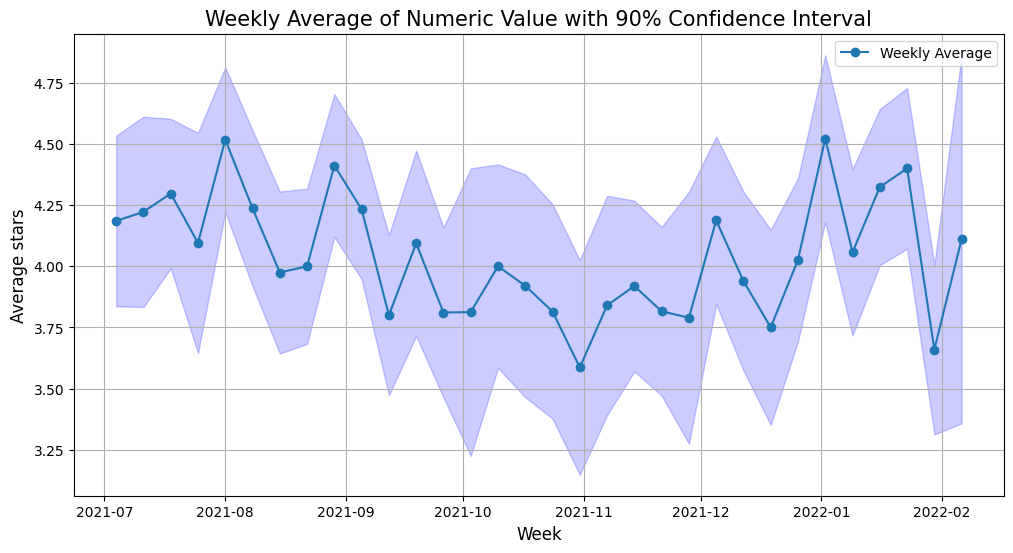

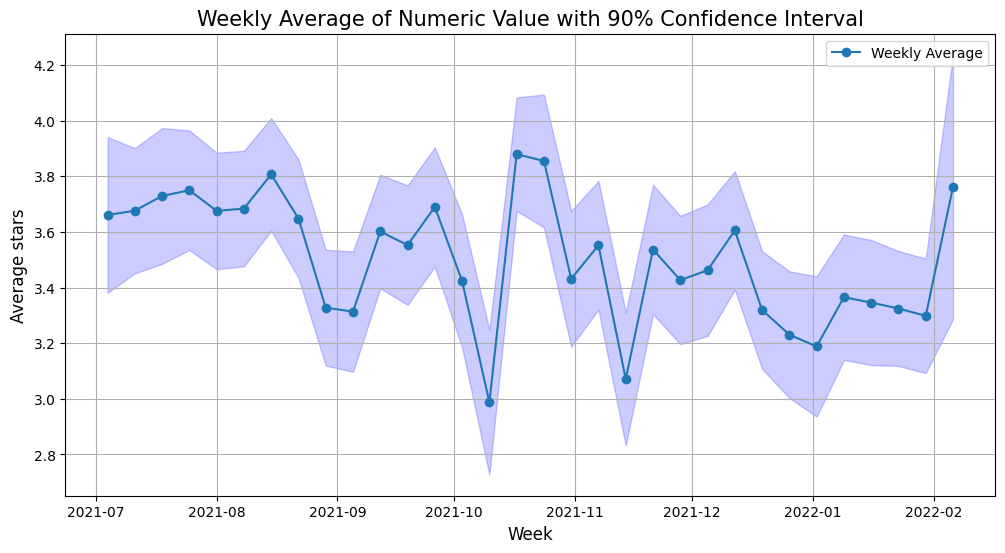

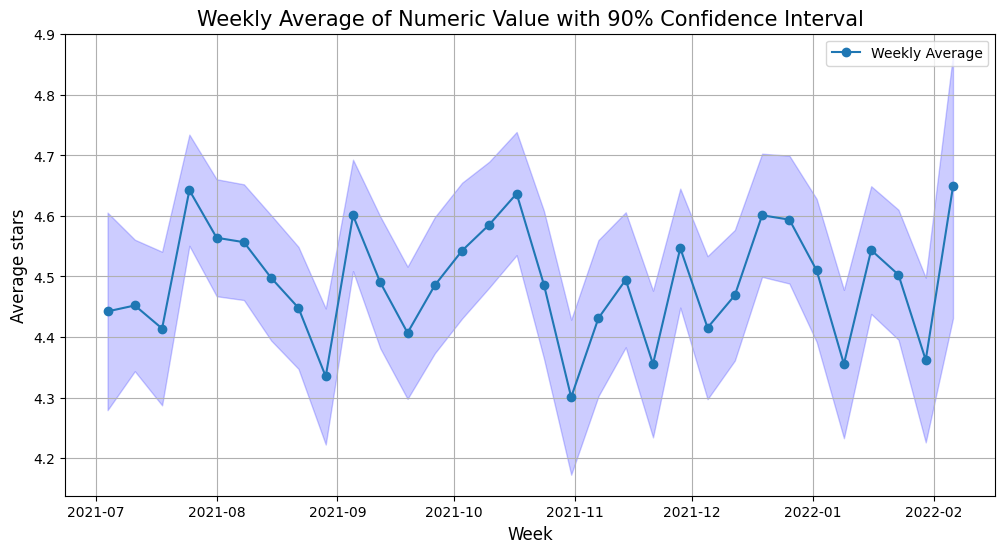

In [55]:
for team in teams:
    selected = final[final.related_team==team]
    time_df = selected[['created_date','label']].set_index('created_date')

    # Resample by week and calculate mean
    weekly_summary = time_df.resample('W').agg({'label': ['mean', 'sem']})
    weekly_summary.columns = weekly_summary.columns.droplevel()

    confidence = st.norm.ppf(0.90)  # Z-score for 90% confidence
    weekly_summary['lower'] = weekly_summary['mean'] - confidence * weekly_summary['sem']
    weekly_summary['upper'] = weekly_summary['mean'] + confidence * weekly_summary['sem']

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_summary.index, weekly_summary['mean'], marker='o', linestyle='-', label='Weekly Average')
    plt.fill_between(weekly_summary.index, weekly_summary['lower'], weekly_summary['upper'], color='b', alpha=0.2)

    plt.title('Weekly Average of Numeric Value with 90% Confidence Interval', fontsize=15)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Average stars', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

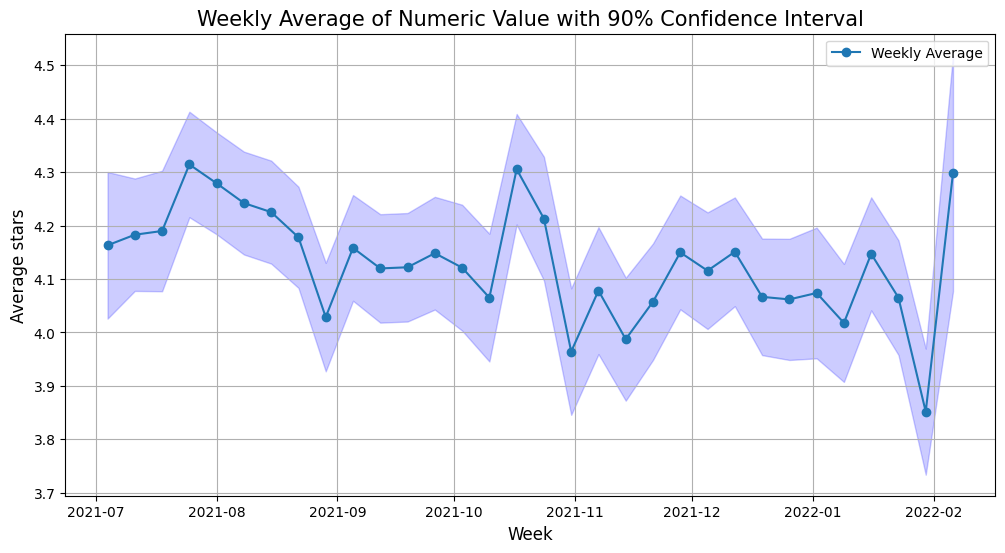

In [59]:
def plot_rating_series(df, team='all', output_file=None):
    if team is None or team != 'all':
        selected = df[df.related_team==team]
    else: 
        selected = df
    time_df = selected[['created_date','label']].set_index('created_date')

    # Resample by week and calculate mean
    weekly_summary = time_df.resample('W').agg({'label': ['mean', 'sem']})
    weekly_summary.columns = weekly_summary.columns.droplevel()

    confidence = st.norm.ppf(0.90)  # Z-score for 90% confidence
    weekly_summary['lower'] = weekly_summary['mean'] - confidence * weekly_summary['sem']
    weekly_summary['upper'] = weekly_summary['mean'] + confidence * weekly_summary['sem']
    # Plotting
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_summary.index, weekly_summary['mean'], marker='o', linestyle='-', label='Weekly Average')
    plt.fill_between(weekly_summary.index, weekly_summary['lower'], weekly_summary['upper'], color='b', alpha=0.2)

    plt.title('Weekly Average of Numeric Value with 90% Confidence Interval', fontsize=15)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Average stars', fontsize=12)
    plt.legend()
    plt.grid(True)
    if output_file is not None:
        plt.savefig(f'{output_file}/rating_series_plot.png')
    plt.show()
plot_rating_series(final, team='all')

In [140]:
# Function to identify trends (more than n weeks)
def identify_trends(data, consecutive_n = 6):
    upward_trend = []
    downward_trend = []
    trend_length = 0
    last_direction = None

    for i in range(1, len(data)):
        if data[i] > data[i - 1]:
            if last_direction == 'up':
                trend_length += 1
            else:
                trend_length = 1
            last_direction = 'up'
        elif data[i] < data[i - 1]:
            if last_direction == 'down':
                trend_length += 1
            else:
                trend_length = 1
            last_direction = 'down'
        else:
            trend_length = 0
            last_direction = None
        n_to_go = consecutive_n
        if trend_length >= consecutive_n:
            if last_direction == 'up':
                upward_trend.append(i)
            elif last_direction == 'down':
                downward_trend.append(i)

    return upward_trend, downward_trend

In [277]:
list(range(1,3))[::-1]

[2, 1]

commercial
[6, 7]


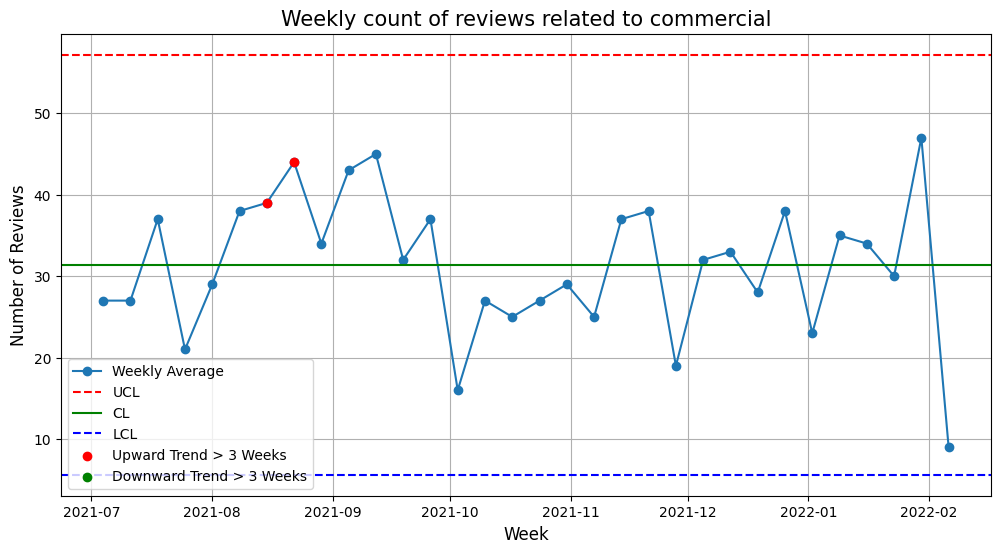

legal
[5, 19]


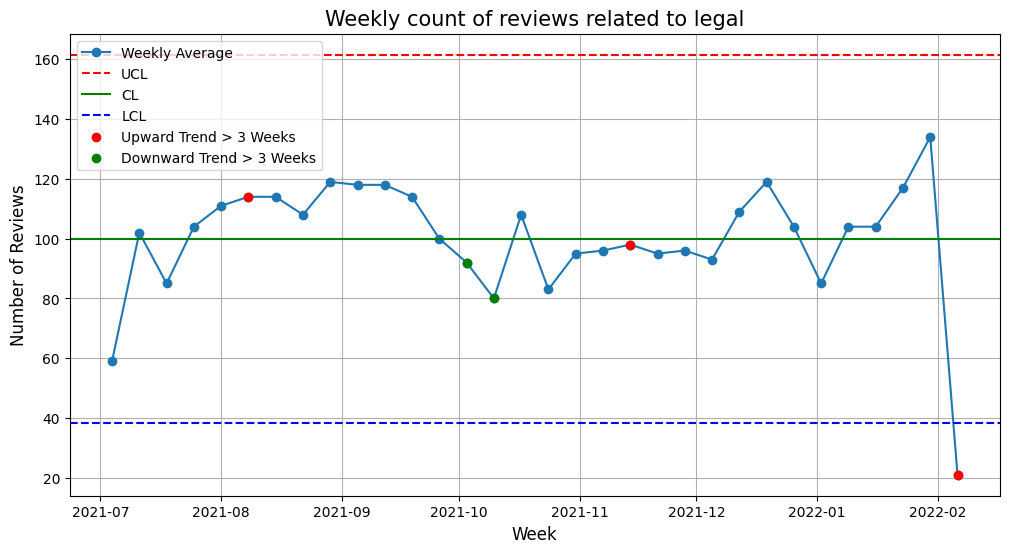

product
[]


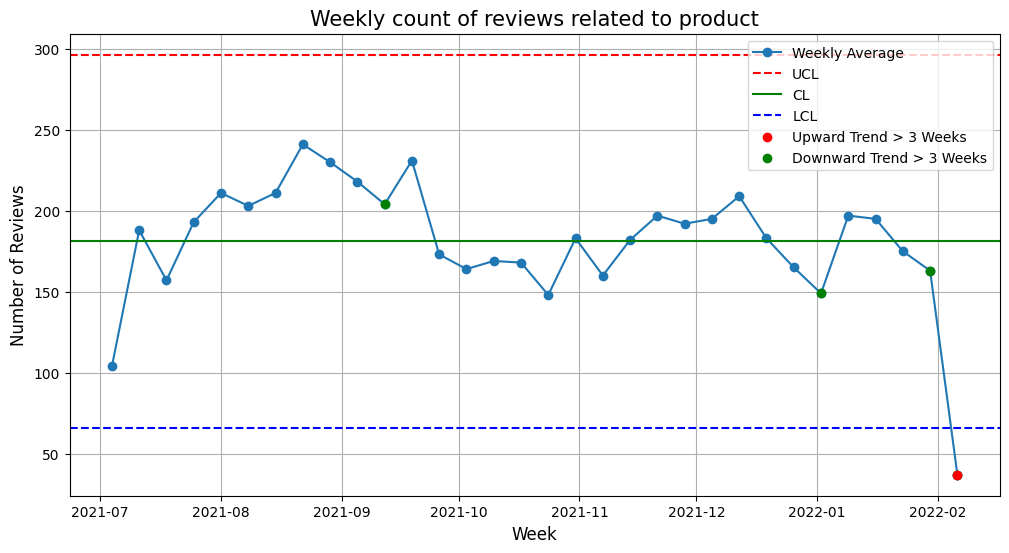

In [155]:
for team in teams:
    print(team)
    selected = final[final.related_team==team]
    time_df = selected[['created_date','label']].set_index('created_date')

        # Resample by week and calculate mean
    weekly_summary = time_df.resample('W').agg({'label': ['count']})
    weekly_summary.columns = weekly_summary.columns.droplevel()
    mean_count = weekly_summary['count'].mean()
    std_count = weekly_summary['count'].std()

    # Calculate control limits
    ucl = mean_count + 3 * std_count
    cl = mean_count
    lcl = mean_count - 3 * std_count

    above_ucl = weekly_summary['count'] > ucl
    below_lcl = weekly_summary['count'] < lcl

    upward_trend, downward_trend = identify_trends(weekly_summary['count'].values, 3)
    print(upward_trend)
    # Plotting with trend identification
    plt.figure(figsize=(12, 6))
    plt.plot(weekly_summary.index, weekly_summary['count'], marker='o', linestyle='-', label='Weekly Average')

    # Add control lines
    plt.axhline(y=ucl, color='r', linestyle='--', label='UCL')
    plt.axhline(y=cl, color='g', linestyle='-', label='CL')
    plt.axhline(y=lcl, color='b', linestyle='--', label='LCL')

    plt.scatter(weekly_summary.iloc[upward_trend].index, weekly_summary.iloc[upward_trend]['count'], color='red', label='Upward Trend > 3 Weeks', zorder=3  )
    plt.scatter(weekly_summary.iloc[downward_trend].index, weekly_summary.iloc[downward_trend]['count'], color='green', label='Downward Trend > 3 Weeks', zorder=3  )
    # Highlight points outside the control limits
    plt.scatter(weekly_summary[above_ucl].index, weekly_summary[above_ucl]['count'], color='red', zorder=3 )
    plt.scatter(weekly_summary[below_lcl].index, weekly_summary[below_lcl]['count'], color='red', zorder=3)


    # Finalize plot
    plt.title('Weekly count of reviews related to ' + team, fontsize=15)
    plt.xlabel('Week', fontsize=12)
    plt.ylabel('Number of Reviews', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()

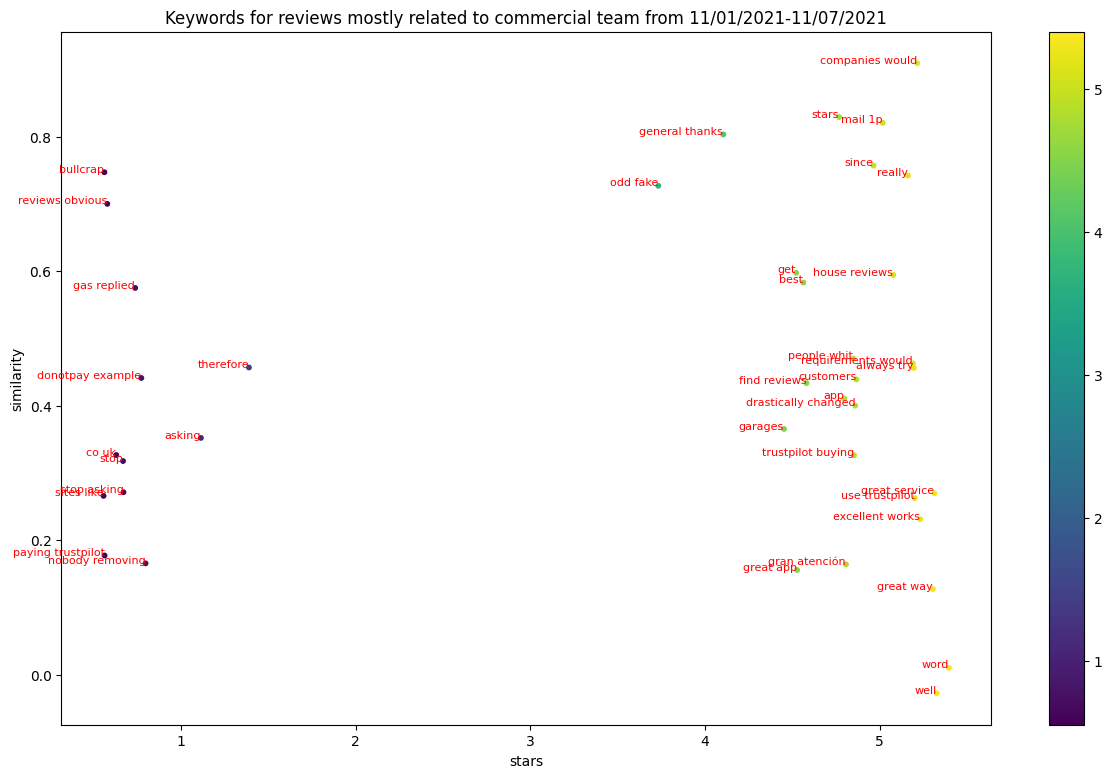

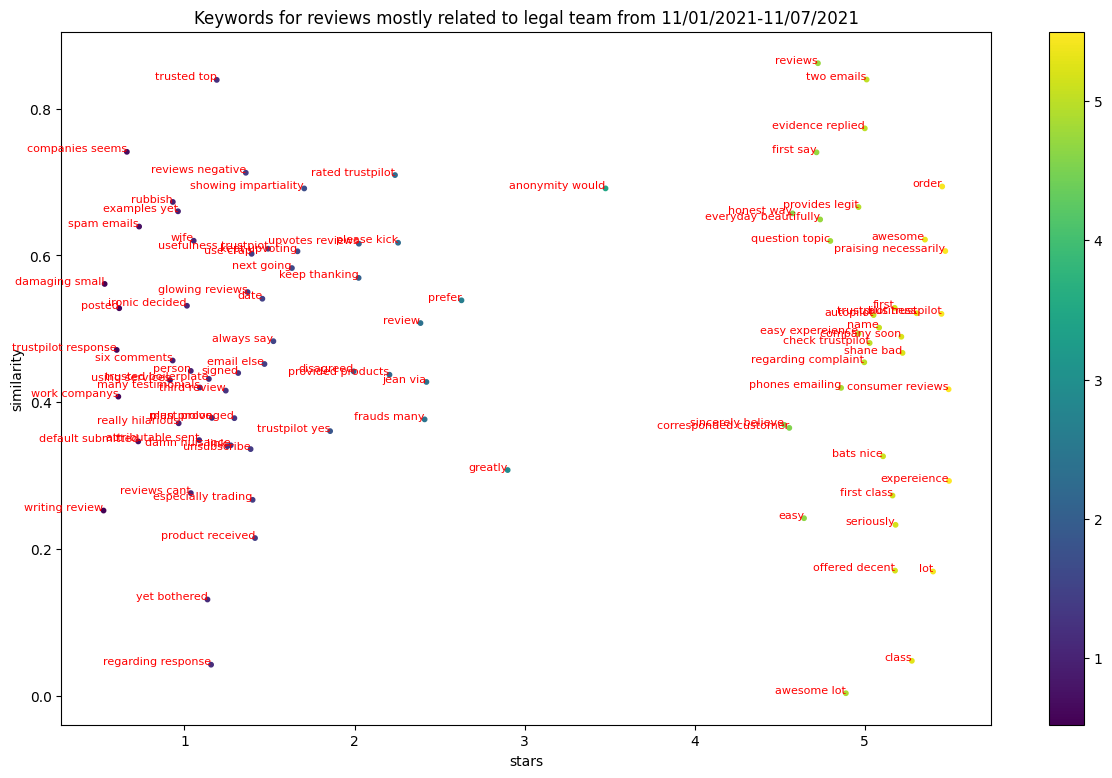

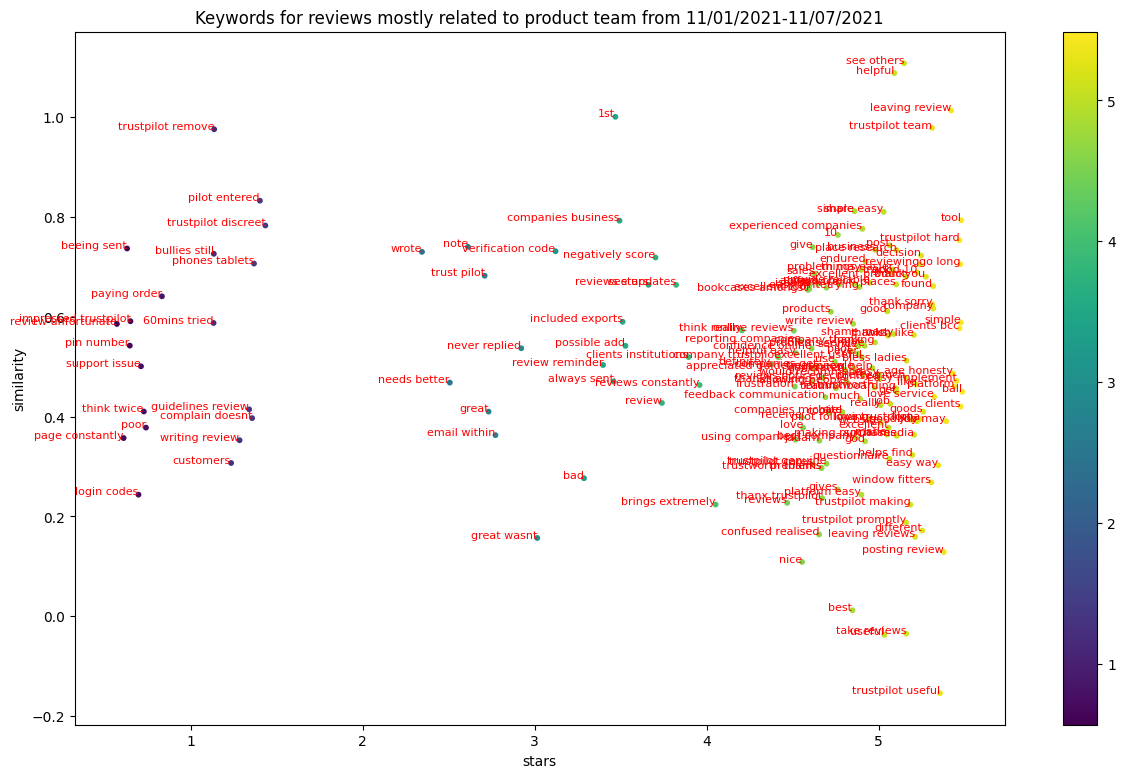

In [224]:
target_month = None
target_year = 2021
start_date = '11/01/2021'
end_date = '11/07/2021'
target_language = 'en'
for team in teams:
    selected = final[final.related_team==team]
    if target_month is not None:
        selected = selected[(selected['created_date'].dt.month == target_month) & (selected['created_date'].dt.year == target_year)]
    else:
        selected = selected[(selected['created_date']>= start_date) & (selected['created_date']< end_date)]
    selected = selected[selected['language'] == target_language]
    selected = pd.melt(selected, value_vars=['keyword_1', 'keyword_2', 'keyword_3'], id_vars=[team,'label']).rename(columns={'value': 'keyword'})
    selected = selected[['keyword', 'label',team]].groupby('keyword').mean().reset_index()
    selected['label'] = selected['label'].apply(lambda x: x+ np.random.rand() -0.5)
    selected[team] = selected[team].apply(lambda x: x+ np.random.normal(0, 0.2) )
    plt.figure(figsize=(15, 9))
    scatter = plt.scatter(selected['label'], selected[team], c=selected['label'], cmap='viridis', s=10)

    # Adding annotations
    for i in range(len(selected)):
        plt.text(selected['label'].iloc[i], selected[team].iloc[i], selected['keyword'].iloc[i], 
                color='red', ha='right', fontsize=8)

    # Adding colorbar
    plt.colorbar(scatter)

    # Setting labels
    plt.xlabel('stars')
    plt.ylabel('similarity')
    if target_month is not None:
        plt.title('Keywords for reviews mostly related to '+ team + ' team in ' +str(target_month) + '-' + str(target_year))
    else:
        plt.title('Keywords for reviews mostly related to '+ team + ' team from ' +str(start_date) + '-' + str(end_date))

    plt.show()

In [169]:
final[(final['created_date'].dt.month == target_month) & (final['created_date'].dt.year == target_year)]


,created_date,label,Title,Text,source,language,text,keyword_1,keyword_2,keyword_3,commercial,legal,product,related_team
4549,2021-10-01 00:08:45+00:00,5,Total faith in trustpilots reviews,Its a good feeling when shopping online and se...,invitationlinkapi,en,Total faith in trustpilots reviews Its a good ...,trustpilot thing,reliability reviews,confidence honesty,0.451401,0.459826,0.517022,product
4550,2021-10-01 03:55:19+00:00,5,So einfach kann es sein,Super einfach beim Schreiben und Lesen Bedien...,basiclink,de,So einfach kann es sein Super einfach beim Sch...,super,bedienerfreundlich,einfach beim,0.312393,0.350464,0.352989,product
4551,2021-10-01 04:25:02+00:00,5,Very helpful if your not sure read the…,Very helpful if your not sure read the reviews!,basiclink,en,Very helpful if your not sure read the reviews!,reviews,read,helpful sure,0.348257,0.449209,0.449304,product
4552,2021-10-01 05:46:22+00:00,5,tout parfait,tout parfait,invitationlinkapi,fr,tout parfait,tout,parfait,tout parfait,0.290515,0.292804,0.307044,product
4553,2021-10-01 05:57:46+00:00,4,Très bon site qui ne censure pas les…,Très bon site qui ne censure pas les avis écri...,invitationlinkapi,fr,Très bon site qui ne censure pas les avis écri...,puisse donné,écrits sans,site censure,0.375266,0.448985,0.402767,legal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5792,2021-10-31 19:43:06+00:00,5,This was my first experience with…,This was my first experience with trustpilot e...,invitationlinkapi,en,This was my first experience with trustpilot e...,first,recommending,experience trustpilot,0.356467,0.404199,0.449558,product
5793,2021-10-31 20:08:08+00:00,2,Ttustpilot: Keep removing ligitimate reviews,Removed 3 reviews on the trot because their so...,organic,en,Ttustpilot: Keep removing ligitimate reviews R...,reviews,removing,ttustpilot keep,0.398979,0.498636,0.449763,legal
5794,2021-10-31 21:34:25+00:00,5,trustpilot.com is the way to get your…,trustpilot.com is the way to get your true tho...,invitationlinkapi,en,trustpilot.com is the way to get your true tho...,lots,get,people brilliant,0.386980,0.331862,0.436427,product
5795,2021-10-31 22:27:51+00:00,5,Es ist gut zu sehen und zu wissen,"Es ist gut zu sehen und zu wissen, das es echt...",organic,de,"Es ist gut zu sehen und zu wissen, das es echt...",meinung hinterlassen,eher bewertungen,interessiert außerdem,0.368331,0.353743,0.334296,commercial


In [189]:
final[['keyword_1', 'label',team]].groupby('keyword_1').mean().reset_index()

,keyword_1,label,commercial
0,00,5.0,0.375442
1,0_0,5.0,0.375180
2,10,5.0,0.314821
3,10 10,5.0,0.346867
4,10 minutter,5.0,0.412203
...,...,...,...
5217,งง,5.0,0.390481
5218,วเองและครอบคร วได,5.0,0.376544
5219,เย,5.0,0.402800
5220,カスタマーサービスの対応は早いですが,1.0,0.356553


In [209]:
# Melting the DataFrame
melted_df = pd.melt(final, value_vars=['keyword_1', 'keyword_2', 'keyword_3'], id_vars=['commercial','label' ]).rename(columns={'value': 'keyword'})

# Selecting only the value column and removing any NaN values
melted_df

,commercial,label,variable,keyword
0,0.401227,1,keyword_1,response
1,0.354044,5,keyword_1,others
2,0.374503,5,keyword_1,opiniones
3,0.272538,5,keyword_1,hjemmeside
4,0.403162,5,keyword_1,check eerst
...,...,...,...,...
29992,0.550078,5,keyword_3,love site
29993,0.387309,5,keyword_3,satisfactory answers
29994,0.399587,5,keyword_3,give honest
29995,0.280864,3,keyword_3,palautuslomakkeen


In [206]:
new_df


,keyword
0,response
1,others
2,opiniones
3,hjemmeside
4,check eerst
...,...
29992,love site
29993,satisfactory answers
29994,give honest
29995,palautuslomakkeen
